# Cell-type Classification on BMNC CITE Seq Data

The CITE-Seq data set consists of two modalities: RNA (Gene Expression) and Protein (Antibody Derived Tags \[ADTs\])

Here, we have also predicted ADT data from XGBoost and cTPnet, based on the measured gene expression.

In this notebook, cell-type classification will be done with the following as input data:
1. Measured gene expression only
2. Measured gene expression and ADT
3. Measured gene expression and XGBoost predicted ADT
4. Measured gene expression and cTPnet predicted ADT

(1) is the control.  
(2) uses a multi-omic approach to determine if the ADT data adds anything of value to the classification task.  
(3) and (4) are used to infer whether the ADT data can be predicted from the gene expression itself, in which case measuring ADTs would become unnecessary. Also, (3) and (4) can be compared to determine which method is better for prediciting ADT values.

In [1]:
# Loading necessary libraries and functions
import sys
sys.path.append('../')
from main import train_model
from experimental import process, train
import pandas as pd
import numpy as np

# File locations
rna_file = "../../CITEseq_BMNC/rna.csv"
adt_file = "../R/CITE_Seq_BMNC/adt.csv"
adt_xgboost_file = "../R/CITE_Seq_BMNC/adt_xgboost.csv"
adt_ctpnet_file = "../R/CITE_Seq_BMNC/adt_ctpnet.csv"
meta_file = "../R/CITE_Seq_BMNC/cell_type.csv"
trte_partition_file = "../R/CITE_Seq_BMNC/trte_partition.txt"

## Measured Gene Expression Only

In [2]:
# Setting all variables for run
# SEED can be "random" or integer, if integer, it will be used as the seed for random, numpy, torch, and cuda
SEED = 42 

# change label from text to integer
#labels = pd.read_csv(meta_file, index_col="cell_id")
#label_dict = dict(zip(set(labels["cell_type"]), range(len(set(labels["cell_type"])))))

COMBINER = False 
doSMOTE = False 

# Training parameters
num_epoch = 400
test_interval = 25
lr = 1e-4
weight_decay = 5e-4
dropout = 0.5
adj_parameter = 10 # average number of edge per node in adj matrix

VERBOSE = 1 #0, only print final result; 1, only testing result; 2, training and testing result
OUTPUT_FILES = False #Boolean to determine whether to output loss and metrics as csv files
MAKE_PLOTS = False #Boolean to determine whether to output loss and metrics as plots in png format
REPEATS = 1 #Integer, how many times to independently train the model
feature_extract = []

In [3]:
RUN_TITLE = "BMNC CITE-Seq RNA Only"
RUN_TITLE_SHORT = "RNA Only"

load_list = [rna_file, meta_file, trte_partition_file]
GCN_names = ["RNA"]

rna = pd.read_csv(rna_file, index_col="cell_id")
meta = pd.read_csv(meta_file, index_col="cell_id")

In [4]:
# Getting labels
#meta = pd.read_csv(meta_file, index_col="cell_id")
#meta = meta.reindex(index=mirna.index)
#labels.iloc[:].value_counts()
label_dict = dict(zip(set(meta["cell_type"]), range(len(set(meta["cell_type"])))))
#labels = [label_dict[x] for x in meta_smol.iloc[:].tolist()]


# Getting training and testing indices
patient_id = rna.index.to_numpy()
with open(trte_partition_file, 'r') as f:
    lines = f.readlines()

tr_patient_id_list = lines[1].strip().split(',')
te_patient_id_list = lines[3].strip().split(',')
tr_idx = [np.where(patient_id == pid)[0][0] for pid in tr_patient_id_list]
te_idx = [np.where(patient_id == pid)[0][0] for pid in te_patient_id_list]
te_idx = sorted(te_idx)

rna_train = rna.iloc[tr_idx,:]
rna_test = rna.iloc[te_idx,:]

meta_train = meta.iloc[tr_idx,:]
meta_test = meta.iloc[te_idx,:]

In [5]:
# A mixture of oversampling and undersampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Setting the target so that the data is undersampled so that every cell_type that has more than 200 samples is reduced to 200
target = meta_train["cell_type"].value_counts().to_dict()
for key in target:
    target[key] = min(target[key],200)

under = RandomUnderSampler(random_state=SEED, sampling_strategy=target)
rna_smol, meta_smol = under.fit_resample(rna_train, meta_train["cell_type"])

# Setting the target so that cell_types with fewer than 200 samples are oversampled to 200
for key in target:
    target[key] = 200
smote = SMOTE(random_state=SEED, sampling_strategy=target)

rna_smol, meta_smol = smote.fit_resample(rna_smol, meta_smol)

In [6]:
tr_idx = list(range(meta_smol.shape[0]))
te_idx = list(range(meta_smol.shape[0], meta_smol.shape[0] + meta_test.shape[0]))

meta_sampled = pd.concat([meta_smol, meta_test["cell_type"]])

label_dict = dict(zip(set(meta["cell_type"]), range(len(set(meta["cell_type"])))))
labels = [label_dict[x] for x in meta_sampled.iloc[:].tolist()]

# Combine rna_smol and rna_test
rna_sampled = pd.concat([rna_smol, rna_test])

In [44]:
meta_sampled

cell_id
a_CATGACAGTTACGACT-1     CD14 Mono
a_CGGCTAGAGTCCAGGA-1     CD14 Mono
a_CACAAACGTGTTGGGA-1     CD14 Mono
a_TTTCCTCTCAGAGACG-1     CD14 Mono
b_GTGAAGGGTAAGAGGA-1     CD14 Mono
                           ...    
a_GGGTCTGCATCTACGA-1    CD4 Memory
b_TGTATTCGTCGAGATG-1       Naive B
b_CCACCTATCACAACGT-1     CD14 Mono
b_ACGGGTCCAGGAATCG-1     CD4 Naive
a_ACACTGAAGGCCCTTG-1    CD4 Memory
Name: cell_type, Length: 20220, dtype: object

In [45]:
rna_sampled

,IGKC,HBA2,HBB,HBA1,IGHA1,IGLC2,JCHAIN,HBM,IGHG1,IGHM,...,INSR,RAD23B,COMMD4,PPARA,PFDN6,PDSS1,BANF1,DDI2,DCAF6,HSPA5
cell_id,,,,,,,,,,,,,,,,,,,,,
a_CATGACAGTTACGACT-1,0.898840,-0.601063,1.319890,-0.488681,-0.552339,-0.612194,-0.325837,-0.182515,-0.202156,2.103580,...,-0.21641,-0.344746,-0.236708,-0.122347,3.963068,-0.131945,-0.507276,-0.173557,-0.198513,-0.439985
a_CGGCTAGAGTCCAGGA-1,0.629265,-0.601063,-0.989970,-0.488681,-0.552339,1.365257,-0.325837,-0.182515,-0.202156,2.423843,...,-0.21641,-0.344746,-0.236708,-0.122347,-0.328409,-0.131945,-0.507276,-0.173557,-0.198513,-0.439985
a_CACAAACGTGTTGGGA-1,0.915253,1.319772,1.046411,-0.488681,-0.552339,1.160504,-0.325837,-0.182515,-0.202156,-0.418009,...,5.79919,-0.344746,-0.236708,-0.122347,-0.328409,10.597873,-0.507276,-0.173557,-0.198513,2.739785
a_TTTCCTCTCAGAGACG-1,-1.047500,-0.601063,0.820612,-0.488681,-0.552339,-0.612194,-0.325837,-0.182515,-0.202156,-0.418009,...,-0.21641,-0.344746,-0.236708,-0.122347,3.426137,-0.131945,-0.507276,-0.173557,-0.198513,-0.439985
b_GTGAAGGGTAAGAGGA-1,-0.040330,0.685976,0.750299,0.899722,-0.552339,-0.612194,-0.325837,-0.182515,-0.202156,-0.418009,...,-0.21641,2.407499,-0.236708,-0.122347,-0.328409,-0.131945,-0.507276,-0.173557,-0.198513,-0.439985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a_GGGTCTGCATCTACGA-1,-1.047500,-0.601063,-0.989970,1.202165,1.328581,-0.612194,1.914741,-0.182515,-0.202156,-0.418009,...,-0.21641,-0.344746,-0.236708,-0.122347,3.209555,-0.131945,-0.507276,-0.173557,-0.198513,-0.439985
b_TGTATTCGTCGAGATG-1,-1.047500,-0.601063,0.650364,-0.488681,-0.552339,2.958775,1.780337,-0.182515,-0.202156,2.716704,...,-0.21641,-0.344746,-0.236708,-0.122347,-0.328409,-0.131945,1.805555,-0.173557,-0.198513,-0.439985
b_CCACCTATCACAACGT-1,0.127958,-0.601063,0.676330,-0.488681,-0.552339,-0.612194,-0.325837,-0.182515,-0.202156,-0.418009,...,-0.21641,-0.344746,-0.236708,-0.122347,-0.328409,-0.131945,-0.507276,-0.173557,-0.198513,-0.439985


In [13]:
# Keeping only the top 5 cell types
A = meta_train["cell_type"].value_counts().to_dict()
top_cell_types = sorted(A, key=A.get, reverse=True)[:5]

# Train set
_meta_train = meta_train[meta_train.cell_type.isin(top_cell_types)]
_rna_train = rna_train[rna_train.index.isin(_meta_train.index)]

from imblearn.under_sampling import RandomUnderSampler
SEED=42
# Setting the target so that the data is undersampled so that every cell_type has 500 samples only
target = _meta_train["cell_type"].value_counts().to_dict()
for key in target:
    target[key] = 1000
under = RandomUnderSampler(random_state=SEED, sampling_strategy=target)
_rna_train, _meta_train = under.fit_resample(_rna_train, _meta_train["cell_type"])

# Test set
_meta_test = meta_test[meta_test.cell_type.isin(top_cell_types)]
_rna_test = rna_test[rna_test.index.isin(_meta_test.index)]

tr_idx = list(range(_meta_train.shape[0]))
te_idx = list(range(_meta_train.shape[0], _meta_train.shape[0] + _meta_test.shape[0]))

meta_sampled = pd.concat([_meta_train, _meta_test["cell_type"]])

label_dict = dict(zip(set(_meta_train), range(len(set(_meta_train)))))
labels = [label_dict[x] for x in meta_sampled.iloc[:].tolist()]

# Combine _rna_train and _rna_test
rna_sampled = pd.concat([_rna_train, _rna_test])

print(_meta_train.shape)
print(_rna_train.shape)
print(_meta_test.shape)
print(_rna_test.shape)
print(rna_sampled.shape)
print(meta_sampled.shape)

(5000,)
(5000, 2000)
(4077, 1)
(4077, 2000)
(9077, 2000)
(9077,)


In [14]:
print(len(tr_idx), len(te_idx))
print(len(labels))

5000 4077
9077


In [15]:
data_list = [rna_sampled]
labels = np.array(labels)
indices = (tr_idx, te_idx)

GCN_names = ["RNA"]
COMBINER = False

data = process(data_list, labels, indices, SEED=SEED)

SEED =  42


In [23]:
# Training parameters
SEED = "random"
num_epoch = 1000
test_interval = 25
lr = 5e-4
weight_decay = 5e-3
dropout = 0.25
adj_parameter = 10 # average number of edge per node in adj matrix

loss_rna, metrics_rna, _, _ = train(data, label_dict=label_dict, GCN_names=GCN_names, COMBINER=COMBINER,
        SEED=SEED, num_epoch=num_epoch, test_interval=test_interval, lr=lr, weight_decay=weight_decay, 
        dropout=dropout, adj_parameter=adj_parameter, VERBOSE=VERBOSE,
        RUN_TITLE=RUN_TITLE, RUN_TITLE_SHORT=RUN_TITLE_SHORT,
        OUTPUT_FILES=OUTPUT_FILES, feature_extract=feature_extract)

#losses_tcga.to_csv("loss_rna.csv")
#metrics_tcga.to_csv("metric_rna.csv")

2021-07-17 22:06:12.248798 

BMNC CITE-Seq RNA Only
SEED =  61748

Training...

Test: Epoch 0
Train Accuracy: 0.1918   Test ACC: 0.2166
Train F1: 0.1311         Test F1: 0.1106

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------
CD4 Naive 	           0.2000              0.0280              0.2217              0.8396
CD8 Naive 	           0.2000              0.0260              0.1921              0.0000
CD4 Memory 	           0.2000              0.0220              0.1651              0.1842
Naive B 	           0.2000              0.2810              0.0979              0.0000
CD14 Mono 	           0.2000              0.6020              0.3233              0.0000


Test: Epoch 25
Train Accuracy: 0.2304   Test ACC: 0.2220
Train F1: 0.2283         Test F1: 0.0872

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
----


Test: Epoch 300
Train Accuracy: 0.2012   Test ACC: 0.3233
Train F1: 0.0808         Test F1: 0.1580

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------
CD4 Naive 	           0.2000              0.0000              0.2217              0.0000
CD8 Naive 	           0.2000              0.0000              0.1921              0.0000
CD4 Memory 	           0.2000              0.0010              0.1651              0.0000
Naive B 	           0.2000              0.0420              0.0979              0.0000
CD14 Mono 	           0.2000              0.9630              0.3233              1.0000


Test: Epoch 325
Train Accuracy: 0.1980   Test ACC: 0.3233
Train F1: 0.0830         Test F1: 0.1580

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
--------------------------------------------------------------------------------


Test: Epoch 600
Train Accuracy: 0.2000   Test ACC: 0.3233
Train F1: 0.0667         Test F1: 0.1580

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------
CD4 Naive 	           0.2000              0.0000              0.2217              0.0000
CD8 Naive 	           0.2000              0.0000              0.1921              0.0000
CD4 Memory 	           0.2000              0.0000              0.1651              0.0000
Naive B 	           0.2000              0.0000              0.0979              0.0000
CD14 Mono 	           0.2000              1.0000              0.3233              1.0000


Test: Epoch 625
Train Accuracy: 0.2000   Test ACC: 0.3233
Train F1: 0.0667         Test F1: 0.1580

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
--------------------------------------------------------------------------------


Test: Epoch 900
Train Accuracy: 0.2038   Test ACC: 0.2217
Train F1: 0.1178         Test F1: 0.0805

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------
CD4 Naive 	           0.2000              0.7880              0.2217              1.0000
CD8 Naive 	           0.2000              0.1890              0.1921              0.0000
CD4 Memory 	           0.2000              0.0000              0.1651              0.0000
Naive B 	           0.2000              0.0420              0.0979              0.0000
CD14 Mono 	           0.2000              0.0000              0.3233              0.0000


Test: Epoch 925
Train Accuracy: 0.2000   Test ACC: 0.2217
Train F1: 0.0667         Test F1: 0.0805

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
--------------------------------------------------------------------------------

<AxesSubplot:>

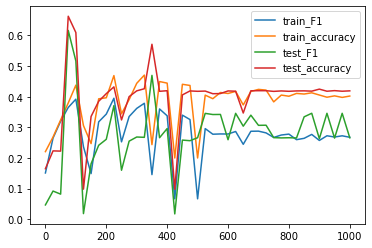

In [21]:
metrics_rna.plot(y = ["train_F1", "train_accuracy", "test_F1", "test_accuracy"])

<AxesSubplot:>

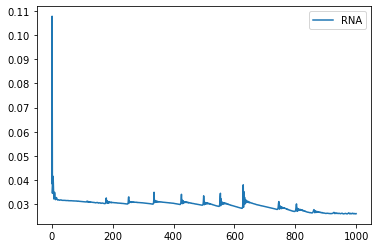

In [22]:
loss_rna.plot()